**Akash Sharma (EE21S056)**

*EE5179: Deep Learning for Imaging*

# Comparing PCA and Autoencoders

## Importing packages

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

## Loading MNIST dataset

In [2]:
training_data = datasets.MNIST(root="data", train=True, download = True,transform = ToTensor())
test_data = datasets.MNIST(root="data", train = False, download = True,transform = ToTensor())

batch_size = 64

train_loader = DataLoader(dataset=training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## MNIST Image Reconstruction using PCA

Reference used: https://analyticsindiamag.com/guide-to-image-reconstruction-using-principal-component-analysis/

In [3]:
# Extracting just images from the dataset for PCA

images = training_data.data 
print(images.shape)

torch.Size([60000, 28, 28])


### Finding indices representing each class

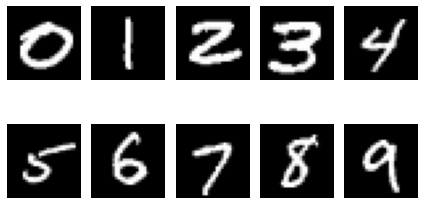

In [4]:
# 114-0, 102-1, 117-2, 111-3, 115-4, 145-5, 106-6, 103-7, 125-8, 110-9 

idx_PCA = [114, 102, 117, 111, 115, 145, 106, 103, 125, 110]

i=1 #just an iterator variable

for idx in idx_PCA:
  plt.subplot(2,5,i)
  plt.imshow(images[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  i+=1
plt.tight_layout()
plt.show()

### Flattening PCA input images

In [5]:
data = np.zeros((60000, 784))
k=0
for img in images:
  data[k] = img.squeeze().flatten()
  data[k] = data[k]/255
  k+=1
print(data.shape)

(60000, 784)


### Performing PCA and checking reconstruction error

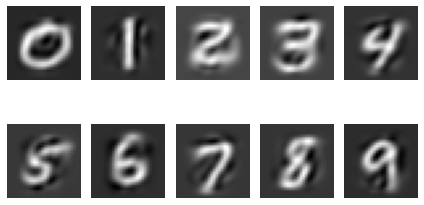

Reconstruction error for PCA is  0.018121815941217218


In [6]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
pca = PCA(n_components=30)
reconst_data = pca.inverse_transform(pca.fit_transform(data))

i = 1

for idx in idx_PCA:
  plt.subplot(2,5,i)
  plt.imshow(reconst_data[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  i+=1

plt.tight_layout()
plt.show()

print('Reconstruction error for PCA is ', mean_squared_error(data, reconst_data))

## Using an Autoencoder on MNIST dataset

### Defining stacked autoencoder class

In [7]:
class stack_AE(nn.Module):
  def __init__(self):
    super(stack_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self, x):
    x = self.flatten(x)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded, encoded

### Autoencoder Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.001
epochs = 10
 
criterion = nn.MSELoss() # Reconstruction error is defined as the MSE Loss

model_stackAE = stack_AE().to(device)
optimizer = torch.optim.Adam(model_stackAE.parameters(), learning_rate)

train_batch_loss = []
train_epoch_loss = []
val_loss = []

In [9]:
for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)

    model_stackAE.train()
    decoded, encoded = model_stackAE(data)
    loss = criterion(decoded, torch.flatten(data,1))
    train_batch_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_epoch_loss.append(train_batch_loss[-1])
  
  model_stackAE.eval()
  with torch.no_grad():
    for (data, target) in test_loader:
      data = data.to(device)
      target = target.to(device)
      decoded, encoded = model_stackAE(data)
      val_iter_loss = criterion(decoded, torch.flatten(data,1))

  val_loss.append(val_iter_loss.item())
  print('Epoch Number: ',epoch+1)
  print('Training loss: ', train_epoch_loss[-1])
  print('Validation loss: ', val_loss[-1])
  print('-----------------------------------------')

print('Training done!')

Epoch Number:  1
Training loss:  0.025514619424939156
Validation loss:  0.025768259540200233
-----------------------------------------
Epoch Number:  2
Training loss:  0.018792742863297462
Validation loss:  0.01956520602107048
-----------------------------------------
Epoch Number:  3
Training loss:  0.018027035519480705
Validation loss:  0.017227349802851677
-----------------------------------------
Epoch Number:  4
Training loss:  0.016422612592577934
Validation loss:  0.015180998481810093
-----------------------------------------
Epoch Number:  5
Training loss:  0.013217149302363396
Validation loss:  0.015349737368524075
-----------------------------------------
Epoch Number:  6
Training loss:  0.01580682583153248
Validation loss:  0.014463952742516994
-----------------------------------------
Epoch Number:  7
Training loss:  0.016053110361099243
Validation loss:  0.01427979115396738
-----------------------------------------
Epoch Number:  8
Training loss:  0.015601414255797863
Vali

### Visualizing training and validation loss for autoencoder

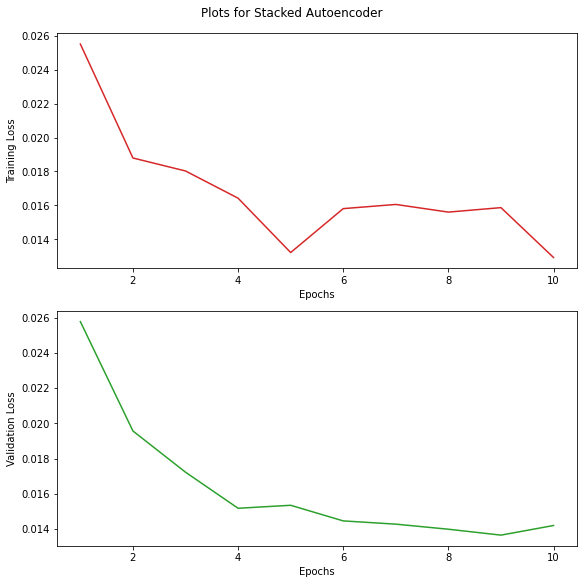

In [10]:
fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
fig.suptitle('Plots for Stacked Autoencoder')
axs[0].set(ylabel='Training Loss', xlabel='Epochs')
axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')

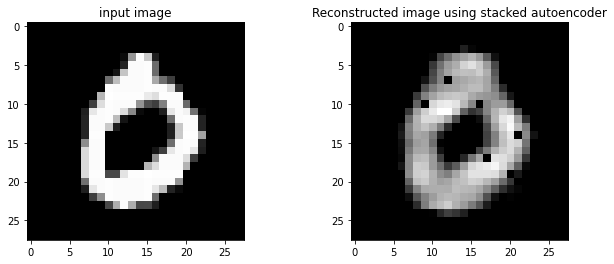

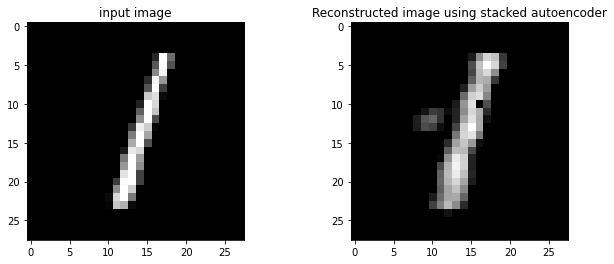

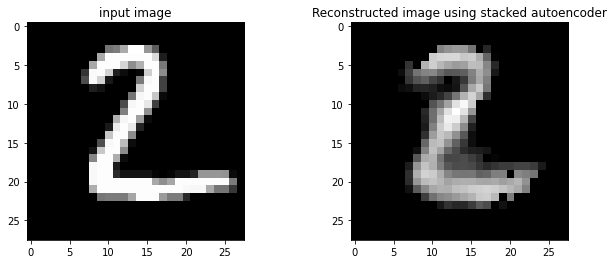

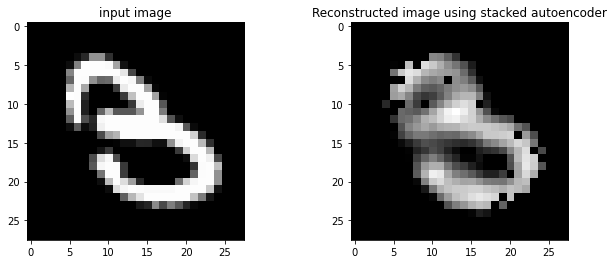

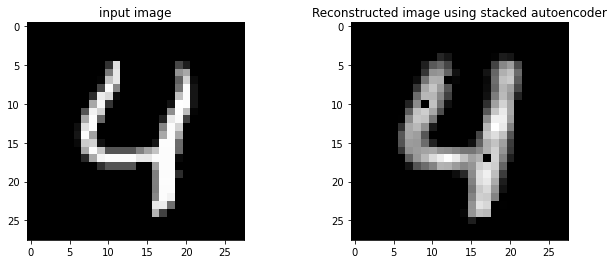

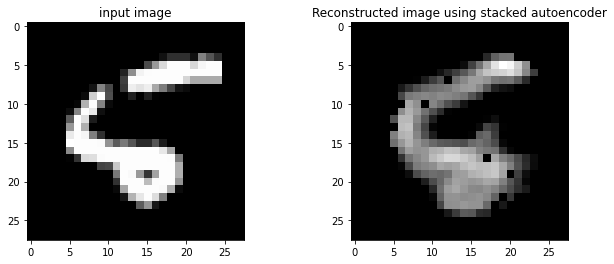

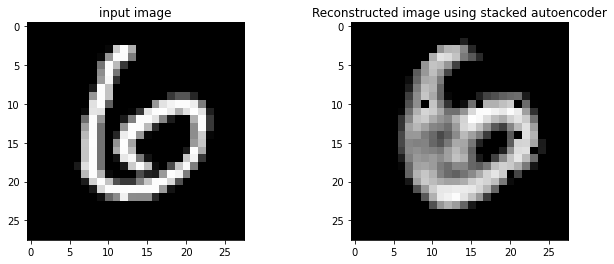

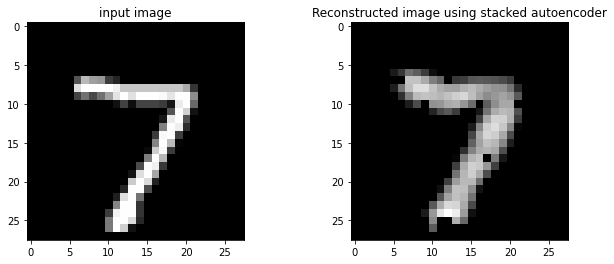

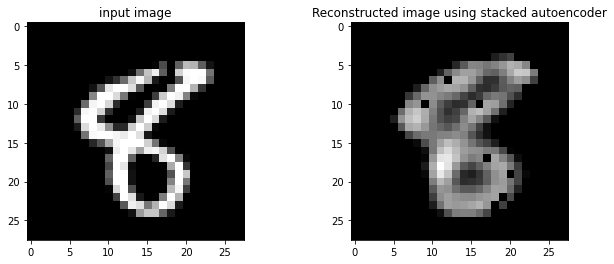

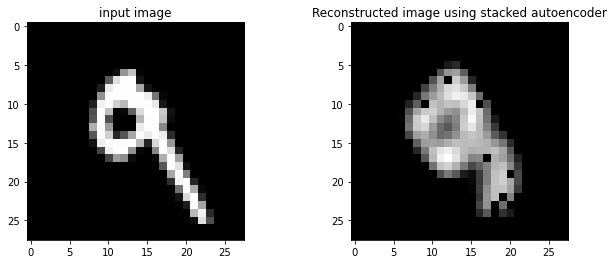

In [11]:
idx_test=[3,2,1,18,4,8,11,0,84,7]

for idx in idx_test:
  image = test_loader.dataset.data[idx, :, :].clone()
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_stackAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using stacked autoencoder")
    plt.show()

In [12]:
model_stackAE.eval()
test_loss = 0
with torch.no_grad():
  for (data, target) in test_loader:
    data = data.to(device)
    target = target.to(device)
    decoded, encoded = model_stackAE(data)
    val_iter_loss = criterion(decoded, torch.flatten(data,1))
    test_loss += val_iter_loss/len(test_loader)
  
print('Reconstruction accuracy with the given autoencoder configuration is ', test_loss.item())

Reconstruction accuracy with the given autoencoder configuration is  0.014440055005252361


# Experimenting with hidden units of varying sizes

## Defining standard autoencoder class

The following model takes the size of hidden layer as input as required by the experiment.

In [13]:
class standard_AE(nn.Module):
  def __init__(self,hidden_layer):
    super(standard_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,hidden_layer),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(hidden_layer,784),
        nn.ReLU())


  def forward(self,x):
    x = self.flatten(x)
    encoded=self.encoder(x)
    decoded =self.decoder(encoded)
    return decoded, encoded 

## Loading Fashion MNIST for experiment

In [14]:
fash_test_data = datasets.FashionMNIST(root="data", train = False, download = True,transform = ToTensor())
fash_test_loader = DataLoader(dataset=fash_test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Training and experiment results

Training begins for hidden unit size  64 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.015205412171781063
Validation loss:  0.014379788190126419
-----------------------------------------
Epoch Number:  2
Training loss:  0.013814076781272888
Validation loss:  0.013476143591105938
-----------------------------------------
Epoch Number:  3
Training loss:  0.013716896064579487
Validation loss:  0.013173110783100128
-----------------------------------------
Epoch Number:  4
Training loss:  0.012501811608672142
Validation loss:  0.013136602006852627
-----------------------------------------
Epoch Number:  5
Training loss:  0.013467206619679928
Validation loss:  0.012923912145197392
-----------------------------------------
Epoch Number:  6
Training loss:  0.011405030265450478
Validation loss:  0.012751072645187378
-----------------------------------------
Epoch Number:  7
Training loss:  0.011586284264922142
Validation loss:  0.0127778733149

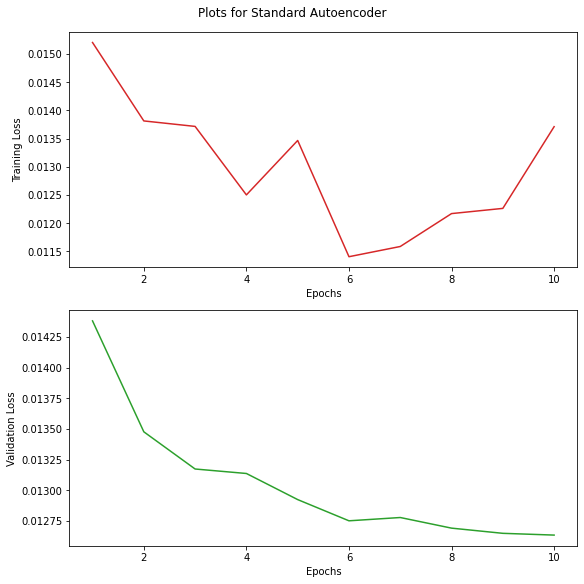

Training done for hidden unit size  64 !
-----------------------------------------------------------


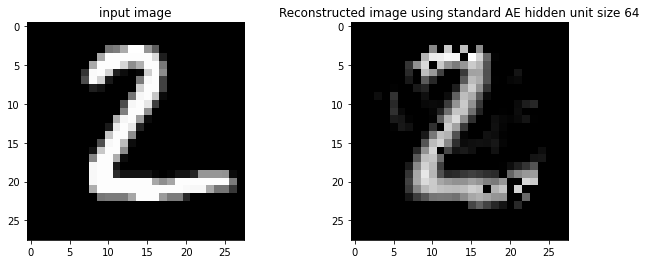

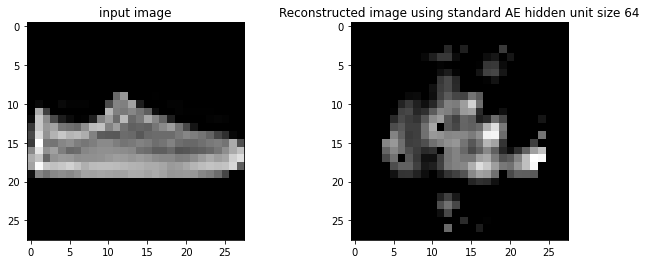

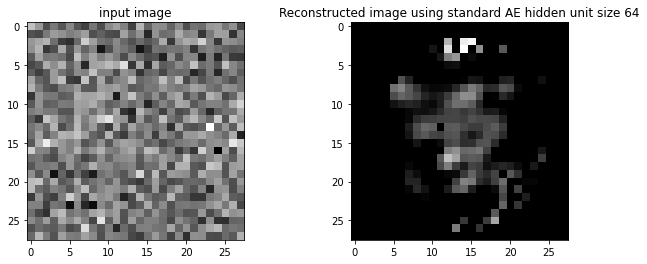

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for hidden unit size  128 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.009362838231027126
Validation loss:  0.010682893916964531
-----------------------------------------
Epoch Number:  2
Training loss:  0.009639010764658451
Validation loss:  0.009487487375736237
-----------------------------------------
Epoch Number:  3
Training loss:  0.008285951800644398
Validation loss:  0.009182061068713665
-----------------------------------------
Epoch Number:  4
Training loss:  0.010454070754349232
Validation loss:  0.009161614812910557
-----------------------------------------
Epoch Number:  5
Training loss:  0.00843499694019556
Validation loss:  0.00904966238886118
-----------------------------------------
Epoch Number:  6
Training loss:  0.009196995757520199
Validation loss:  0.008906994014978409
----------

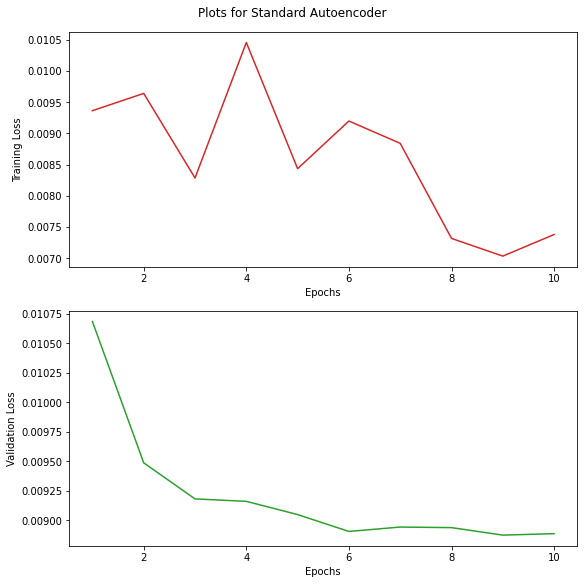

Training done for hidden unit size  128 !
-----------------------------------------------------------


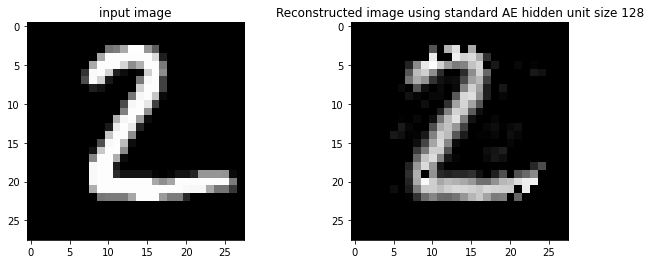

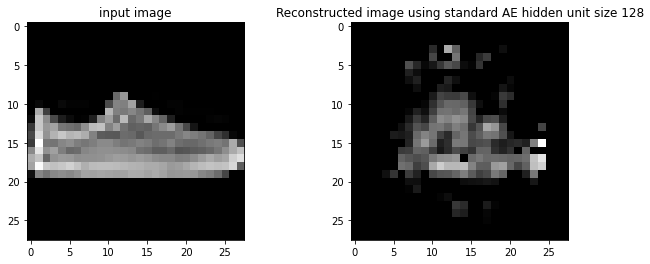

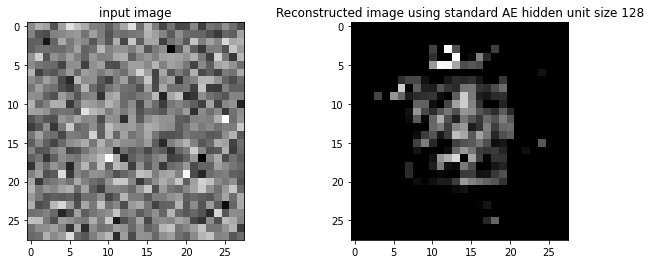

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for hidden unit size  256 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.010379760526120663
Validation loss:  0.009749290533363819
-----------------------------------------
Epoch Number:  2
Training loss:  0.008854160085320473
Validation loss:  0.008706873282790184
-----------------------------------------
Epoch Number:  3
Training loss:  0.007910887710750103
Validation loss:  0.008333210833370686
-----------------------------------------
Epoch Number:  4
Training loss:  0.008666816167533398
Validation loss:  0.008095543831586838
-----------------------------------------
Epoch Number:  5
Training loss:  0.00818319246172905
Validation loss:  0.008007722906768322
-----------------------------------------
Epoch Number:  6
Training loss:  0.007989658042788506
Validation loss:  0.007964433170855045
---------

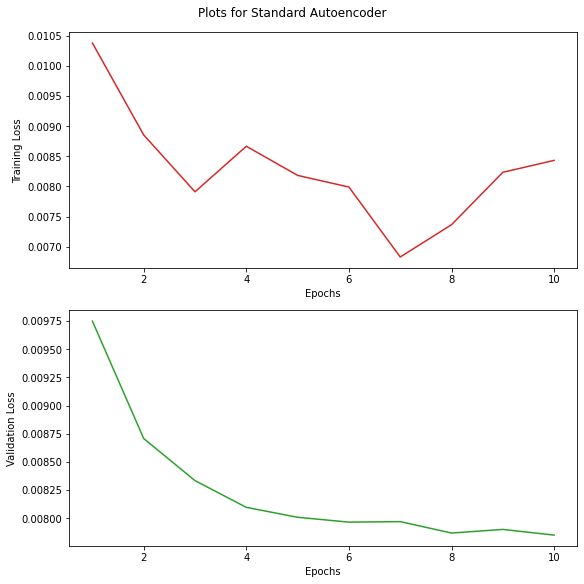

Training done for hidden unit size  256 !
-----------------------------------------------------------


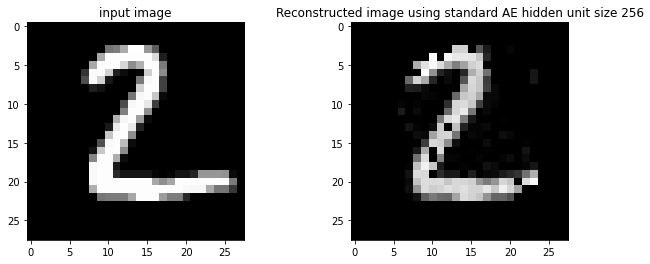

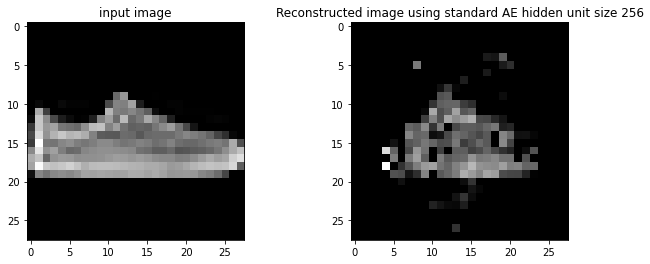

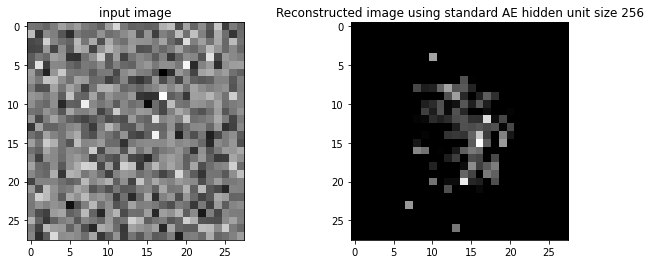

-----------------------------------------------------------
-----------------------------------------------------------


In [15]:
hid_size = [64, 128, 256]

for size in hid_size:
  model_standardAE = standard_AE(size).to(device)
  optimizer = torch.optim.Adam(model_standardAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = [] 
  print('Training begins for hidden unit size ', size, '!')
  print('-----------------------------------------------------------')
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device=device)
      target = target.to(device=device)

      model_standardAE.train()
      decoded, encoded = model_standardAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_standardAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        data = data.to(device)
        target = target.to(device)
        decoded, encoded = model_standardAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')


  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for hidden unit size ', size, '!')
  print('-----------------------------------------------------------')
  image = test_loader.dataset.data[1, :, :].clone() #take one image from test set
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()
    
    fash_image = fash_test_loader.dataset.data[12, :, :].clone()
    fash_image = fash_image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(fash_image)
    decoded = decoded.detach().cpu().numpy()
    fash_image = fash_image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(fash_image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()


    noisy_img = np.random.normal(loc=128,scale=10,size=(28,28))
    noisy_img = torch.from_numpy(noisy_img).reshape(1,1,28,28).to(device=device).float()
    decoded, encoded = model_standardAE.forward(noisy_img)
    decoded = decoded.detach().cpu().numpy()
    noisy_img = noisy_img.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(noisy_img , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using standard AE hidden unit size "+str(size))
    plt.show()
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

# Sparse Autoencoders

## Defining sparse autoencoder class

In [16]:
class overcomp_sparse_AE(nn.Module):
  def __init__(self):
    super(overcomp_sparse_AE, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(784,1521),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1521,784),
        nn.ReLU())


  def forward(self,x):
    x = self.flatten(x)
    encoded=self.encoder(x)
    decoded =self.decoder(encoded)
    return decoded, encoded

## Defining experimentation functions

- Average hidden layer activation `avg_hl_activations`
- Visualize activations `visualize_activations`
- Visualize learned filters `encoder_decoder_filters_plots`

In [17]:
def avg_hl_activations(model,test_dataloader,model_name):
    model.eval() 
    avg_act_val = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: 
            (data,label) = (data.to(device),label.to(device))  
            decoded,encoded = model(data) #our prediction 
            avg_act_val += float(torch.mean(encoded))        
    avg_act_val /= len(test_dataloader)
    print("The average activation of "+ str(model_name)+" is",avg_act_val)

def encoder_decoder_filters_plots(model,model_name,device): 
    with torch.no_grad():
        encoder_filters = model.encoder[0].weight.detach().cpu().numpy()
        decoder_filters = model.decoder[0].weight.detach().cpu().numpy()
        #plot the encoder and decoder weights as an image for 0th neuron
        plt.imshow(encoder_filters[0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Encoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

        plt.imshow(decoder_filters[:,0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Decoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

def visualize_activations(model,test_dataloader,model_name,device,hidden_layer): #visualize the activations
    for i,ind in enumerate(idx_test):
        test_image = test_dataloader.dataset.data[ind].clone()  
        test_label = test_dataloader.dataset.targets[ind].clone()
        with torch.no_grad(): 
            test_image = test_image.reshape(1,1,28,28).to(device=device).float() 
            decoded,encoded = model.forward(test_image) 
            encoded = encoded.detach().cpu().numpy()
            plt.imshow(encoded.reshape(int(np.sqrt(hidden_layer)),int(np.sqrt(hidden_layer))), cmap='gray') 
            str_title = "Activation for digit "+str(test_label.item())
            plt.title(str_title)
            plt.show()

Training begins for regularization lambda value  0.0001 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.015572241507470608
Validation loss:  0.015071733854711056
-----------------------------------------
Epoch Number:  2
Training loss:  0.014412588439881802
Validation loss:  0.015841398388147354
-----------------------------------------
Epoch Number:  3
Training loss:  0.015103071928024292
Validation loss:  0.01383668091148138
-----------------------------------------
Epoch Number:  4
Training loss:  0.01100159715861082
Validation loss:  0.013298295438289642
-----------------------------------------
Epoch Number:  5
Training loss:  0.012901985086500645
Validation loss:  0.012650098651647568
-----------------------------------------
Epoch Number:  6
Training loss:  0.013376357965171337
Validation loss:  0.012648377567529678
-----------------------------------------
Epoch Number:  7
Training loss:  0.009877783246338367
Validation loss:  0.

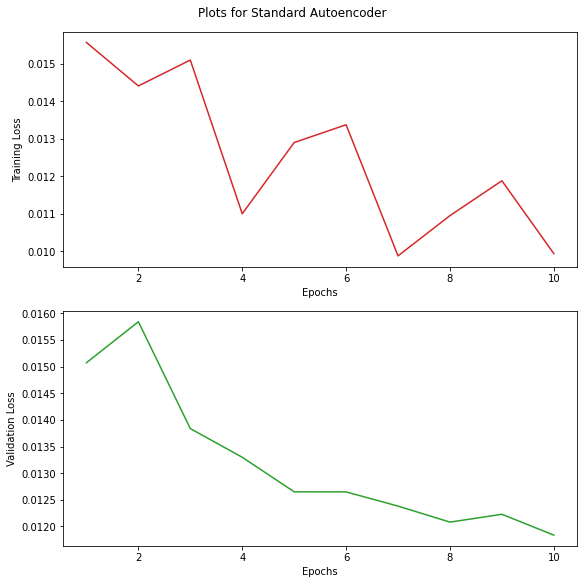

Training done for regularization lambda value  0.0001 !
-----------------------------------------------------------


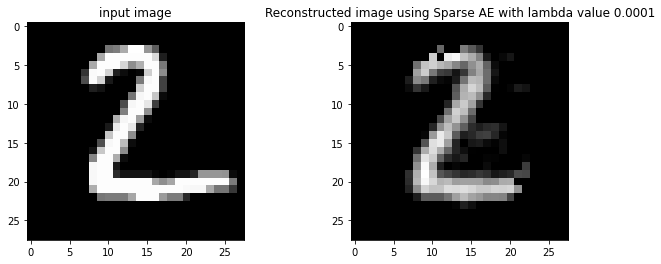

The average activation of Sparse AE with lambda value 0.0001 is 0.024317094676528768


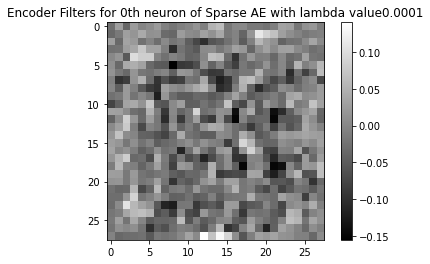

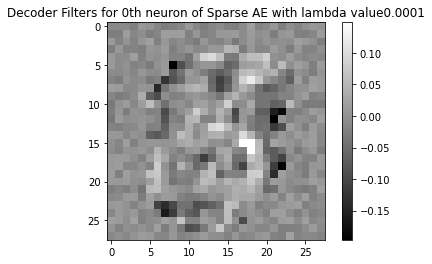

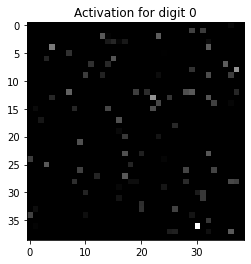

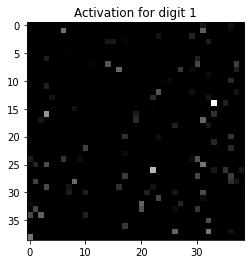

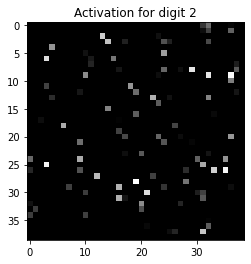

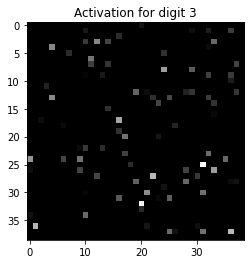

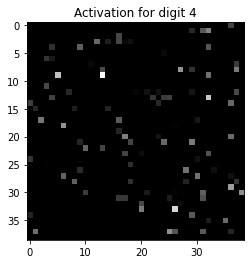

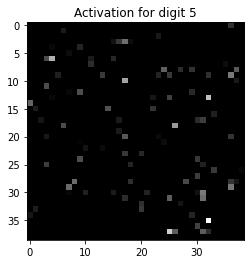

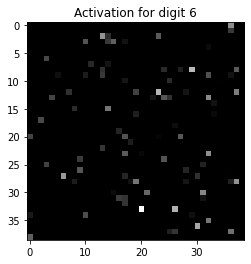

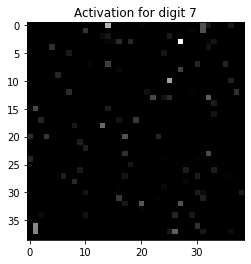

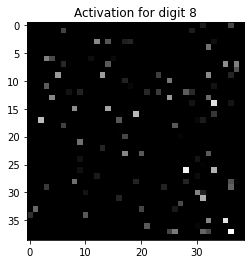

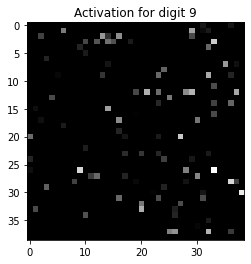

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for regularization lambda value  0.001 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.03657766059041023
Validation loss:  0.02819947898387909
-----------------------------------------
Epoch Number:  2
Training loss:  0.03130034729838371
Validation loss:  0.030439140275120735
-----------------------------------------
Epoch Number:  3
Training loss:  0.03125472366809845
Validation loss:  0.027336187660694122
-----------------------------------------
Epoch Number:  4
Training loss:  0.026766687631607056
Validation loss:  0.02722999081015587
-----------------------------------------
Epoch Number:  5
Training loss:  0.023902306333184242
Validation loss:  0.0263354554772377
-----------------------------------------
Epoch Number:  6
Training loss:  0.02719135954976082
Validation loss:  0.026311347261071205
---

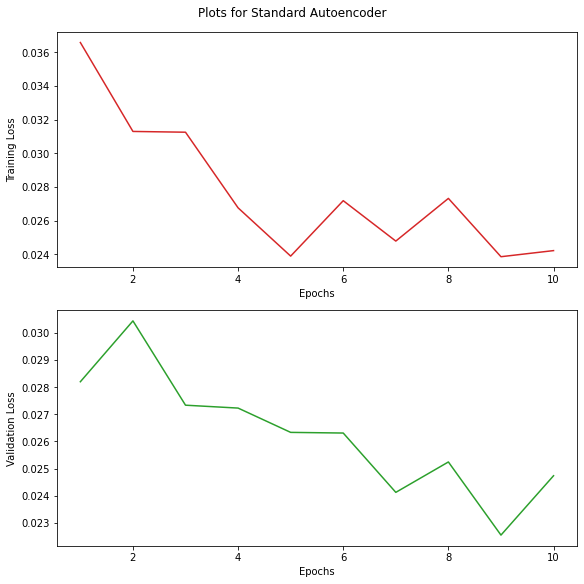

Training done for regularization lambda value  0.001 !
-----------------------------------------------------------


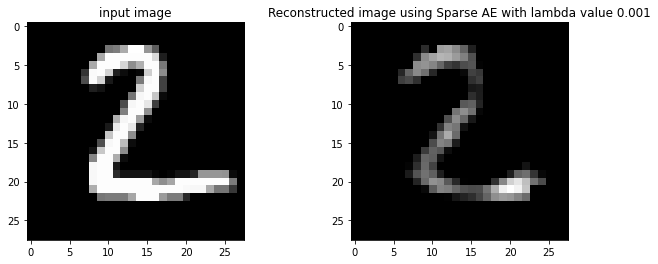

The average activation of Sparse AE with lambda value 0.001 is 0.005339490537454558


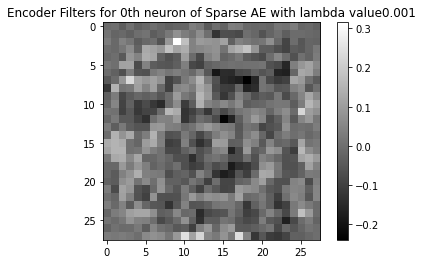

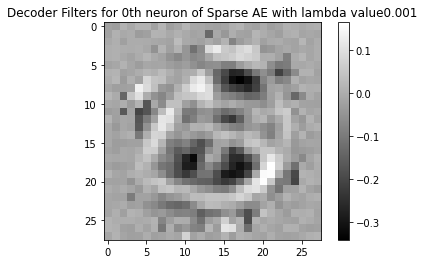

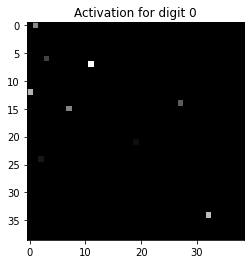

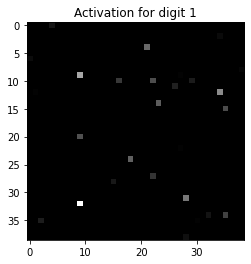

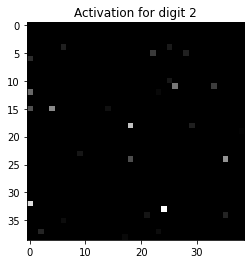

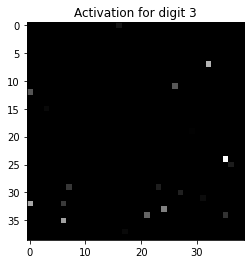

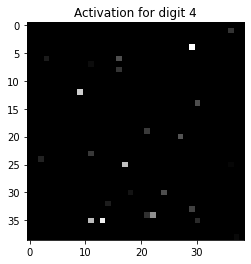

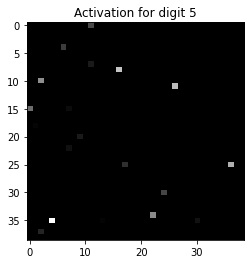

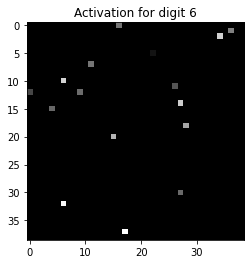

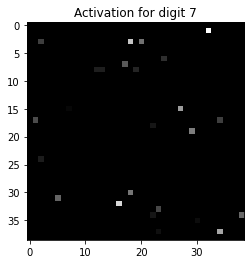

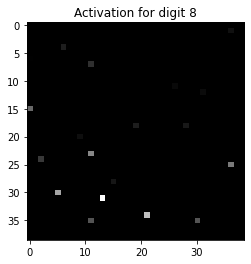

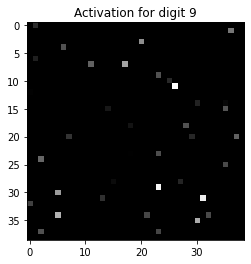

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for regularization lambda value  0.005 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.14927056431770325
Validation loss:  0.09885752201080322
-----------------------------------------
Epoch Number:  2
Training loss:  0.05682261288166046
Validation loss:  0.06706684827804565
-----------------------------------------
Epoch Number:  3
Training loss:  0.05783994868397713
Validation loss:  0.0616452656686306
-----------------------------------------
Epoch Number:  4
Training loss:  0.04894670844078064
Validation loss:  0.05445782095193863
-----------------------------------------
Epoch Number:  5
Training loss:  0.0468580424785614
Validation loss:  0.053544532507658005
-----------------------------------------
Epoch Number:  6
Training loss:  0.056293077766895294
Validation loss:  0.056057292968034744
------

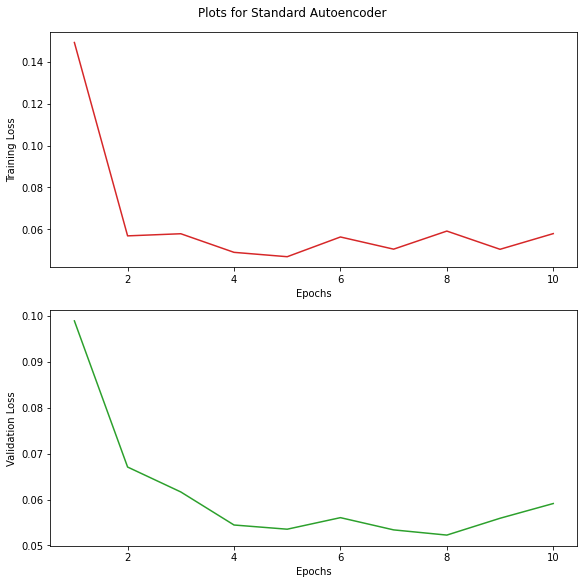

Training done for regularization lambda value  0.005 !
-----------------------------------------------------------


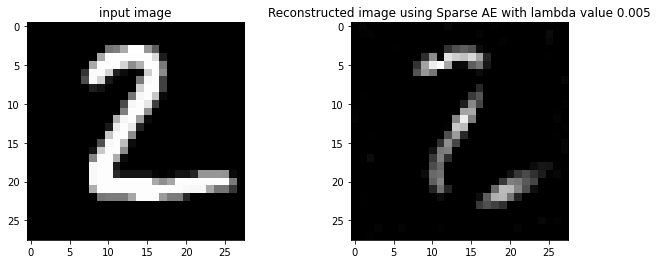

The average activation of Sparse AE with lambda value 0.005 is 0.0010910846091284874


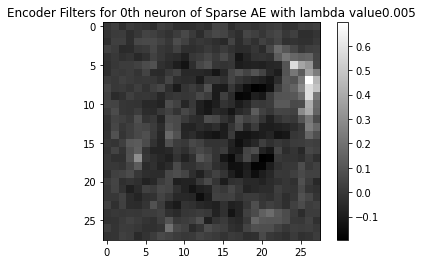

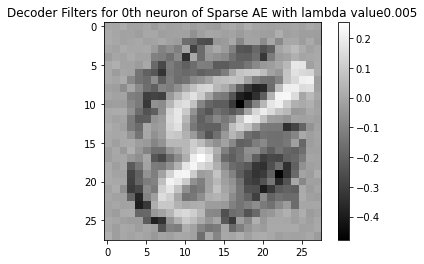

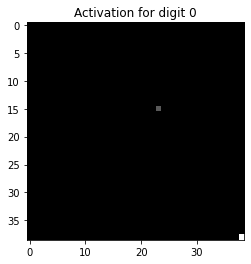

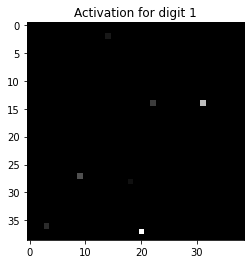

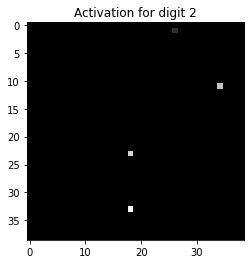

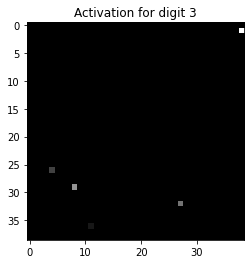

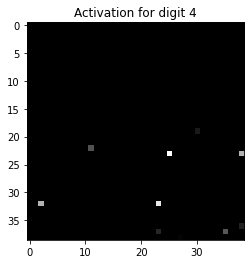

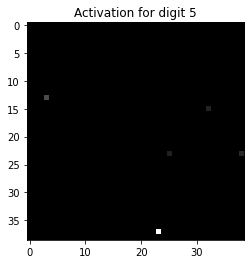

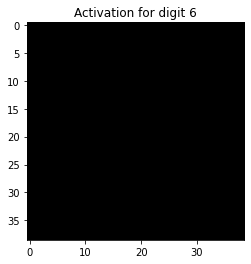

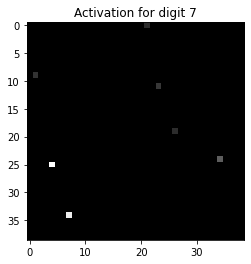

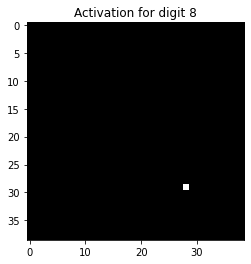

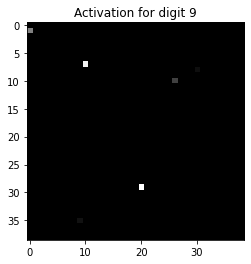

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for regularization lambda value  0.1 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  2.71380352973938
Validation loss:  1.5620596408843994
-----------------------------------------
Epoch Number:  2
Training loss:  0.14296624064445496
Validation loss:  0.1392284780740738
-----------------------------------------
Epoch Number:  3
Training loss:  0.11376488953828812
Validation loss:  0.1082632914185524
-----------------------------------------
Epoch Number:  4
Training loss:  0.07981755584478378
Validation loss:  0.09571825712919235
-----------------------------------------
Epoch Number:  5
Training loss:  0.0655784159898758
Validation loss:  0.07309792935848236
-----------------------------------------
Epoch Number:  6
Training loss:  0.06599514186382294
Validation loss:  0.07321781665086746
----------------

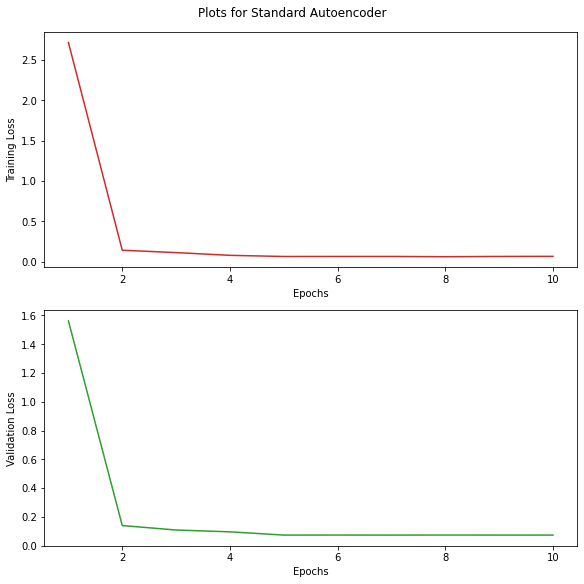

Training done for regularization lambda value  0.1 !
-----------------------------------------------------------


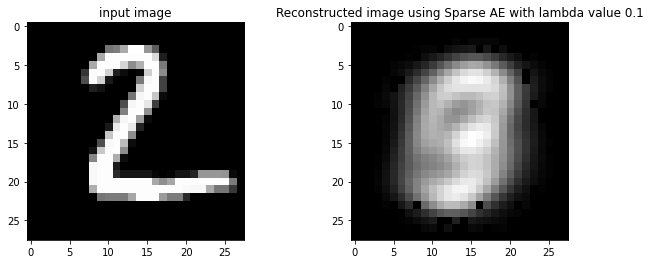

The average activation of Sparse AE with lambda value 0.1 is 4.6114608687622034e-07


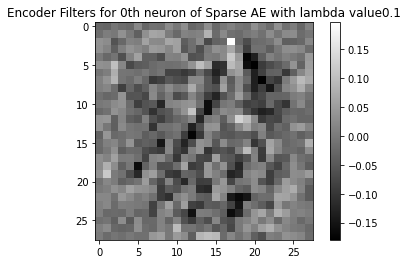

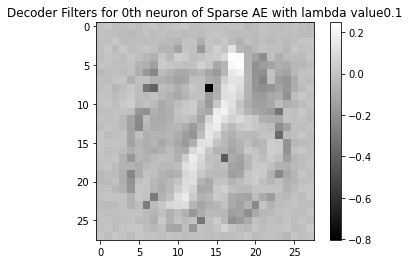

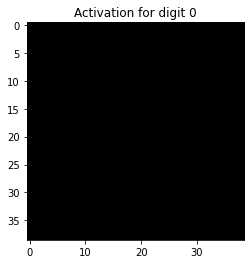

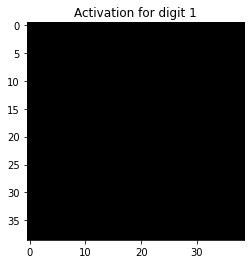

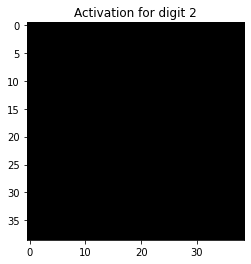

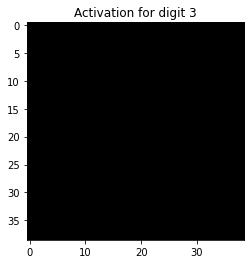

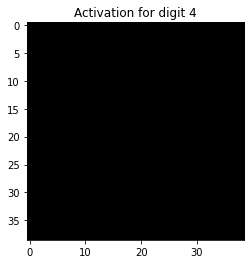

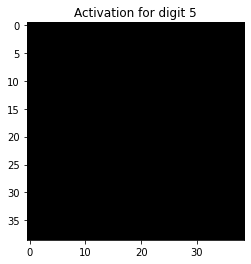

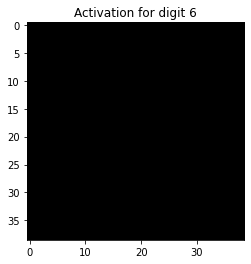

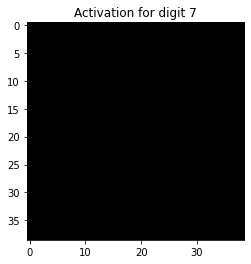

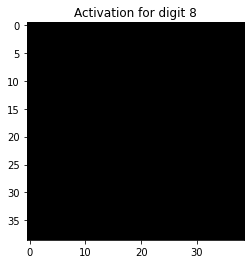

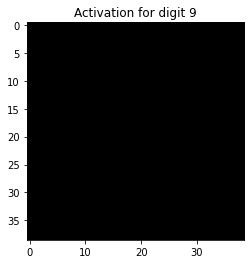

-----------------------------------------------------------
-----------------------------------------------------------


In [18]:
sparsity_values = [0.0001, 0.001, 0.005, 0.1]

for lam in sparsity_values:
  model_over_sparseAE = overcomp_sparse_AE().to(device)
  optimizer = torch.optim.Adam(model_over_sparseAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = []
  print('Training begins for regularization lambda value ', lam, '!')
  print('-----------------------------------------------------------')
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device=device)
      target = target.to(device=device)

      model_over_sparseAE.train()
      decoded, encoded = model_over_sparseAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      loss+= lam*torch.linalg.norm(encoded, 1)
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_over_sparseAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        data = data.to(device)
        target = target.to(device)

        decoded, encoded = model_over_sparseAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))
        val_iter_loss += lam*torch.linalg.norm(encoded, 1)

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')

  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for regularization lambda value ', lam, '!')
  print('-----------------------------------------------------------')
  image = test_loader.dataset.data[1, :, :].clone() #take one image from test set
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_over_sparseAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using Sparse AE with lambda value "+str(lam))
    plt.show()
    avg_hl_activations(model_over_sparseAE,test_loader,"Sparse AE with lambda value "+str(lam))
    encoder_decoder_filters_plots(model_over_sparseAE,"Sparse AE with lambda value"+str(lam),device)
    visualize_activations(model_over_sparseAE,test_loader,"Sparse AE with lambda value"+str(lam),device,1521)
  print('-----------------------------------------------------------')
  print('-----------------------------------------------------------')

**Observations**

- For different sparsity values, it can be noted that for higher sparsity values the reconstruction is recognizable but not perfect in the sense that the strokes of digits are not continuous. However, for lower sparsity values, the reconstruction includes more pixels as part of the reconstructions making it more noisy. 
 
- This can also be interpreted using the activation filters shown above, as the sparsity value is increased, the activation for each digit also becomes sparse.

- For the highest sparsity value (`lambda` value) chosen, it can be noticed that the activation for any digit is almost blank, it also reflects in the reconstructed image as it does not resemble the chosen digit at all.

# Denoising Autoencoders

## Experimentation with different noise values

Training begins for noise value  0.3 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.07919100672006607
Validation loss:  0.07763116806745529
-----------------------------------------
Epoch Number:  2
Training loss:  0.07891659438610077
Validation loss:  0.07751056551933289
-----------------------------------------
Epoch Number:  3
Training loss:  0.07668483257293701
Validation loss:  0.07605963945388794
-----------------------------------------
Epoch Number:  4
Training loss:  0.07608699053525925
Validation loss:  0.0766594409942627
-----------------------------------------
Epoch Number:  5
Training loss:  0.07629714161157608
Validation loss:  0.07491587102413177
-----------------------------------------
Epoch Number:  6
Training loss:  0.07539673149585724
Validation loss:  0.0753844678401947
-----------------------------------------
Epoch Number:  7
Training loss:  0.07666618376970291
Validation loss:  0.07418350130319595
--------------

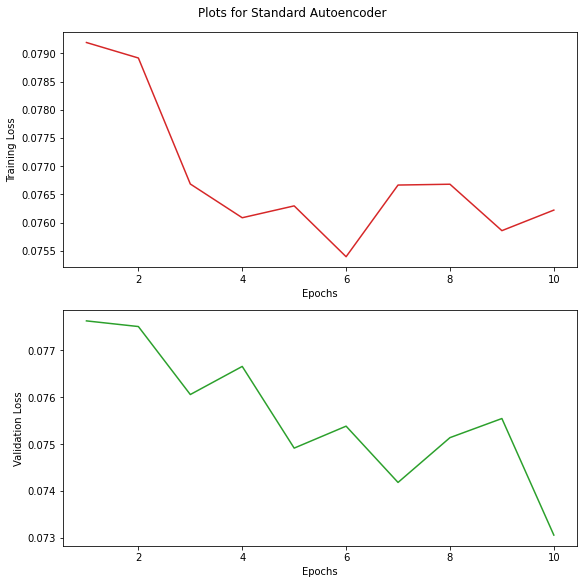

Training done for denoising AE with noise value 0.3 !
-----------------------------------------------------------


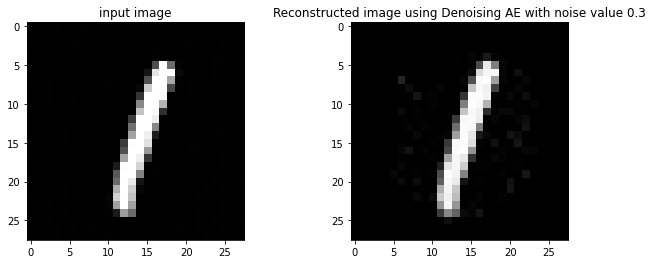

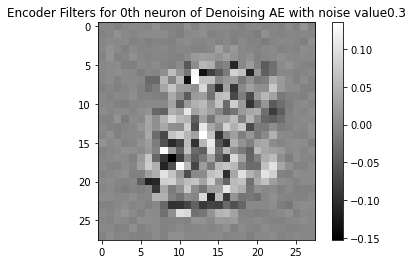

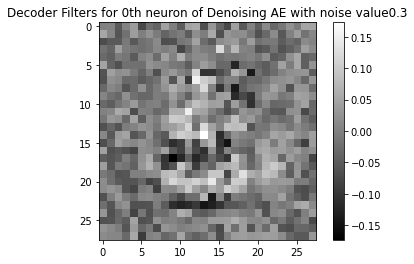

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for noise value  0.5 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.2066396325826645
Validation loss:  0.20023320615291595
-----------------------------------------
Epoch Number:  2
Training loss:  0.19966499507427216
Validation loss:  0.19900991022586823
-----------------------------------------
Epoch Number:  3
Training loss:  0.2001471221446991
Validation loss:  0.1935756355524063
-----------------------------------------
Epoch Number:  4
Training loss:  0.20333196222782135
Validation loss:  0.19886252284049988
-----------------------------------------
Epoch Number:  5
Training loss:  0.1990119367837906
Validation loss:  0.1963425874710083
-----------------------------------------
Epoch Number:  6
Training loss:  0.19856153428554535
Validation loss:  0.19486773014068604
------------------------------

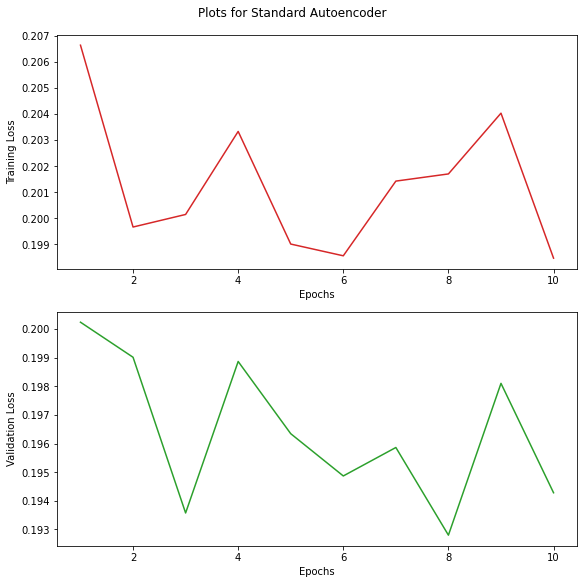

Training done for denoising AE with noise value 0.5 !
-----------------------------------------------------------


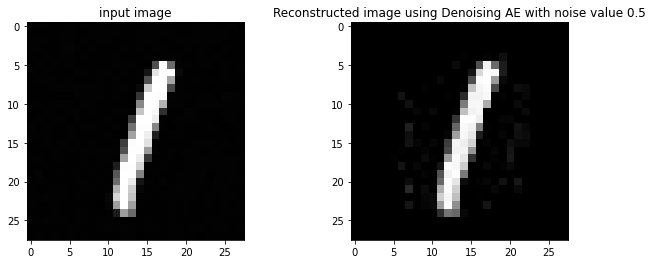

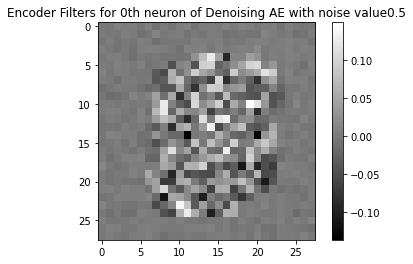

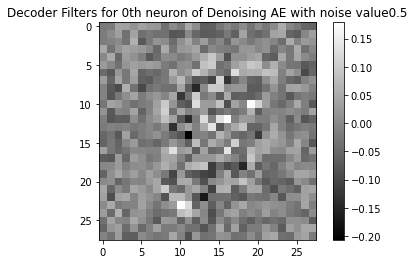

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for noise value  0.8 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.5117299556732178
Validation loss:  0.5008126497268677
-----------------------------------------
Epoch Number:  2
Training loss:  0.516144871711731
Validation loss:  0.5109405517578125
-----------------------------------------
Epoch Number:  3
Training loss:  0.5085366368293762
Validation loss:  0.5050548315048218
-----------------------------------------
Epoch Number:  4
Training loss:  0.5145164132118225
Validation loss:  0.5008255839347839
-----------------------------------------
Epoch Number:  5
Training loss:  0.5108858942985535
Validation loss:  0.4850398302078247
-----------------------------------------
Epoch Number:  6
Training loss:  0.516089677810669
Validation loss:  0.49766290187835693
--------------------------------------

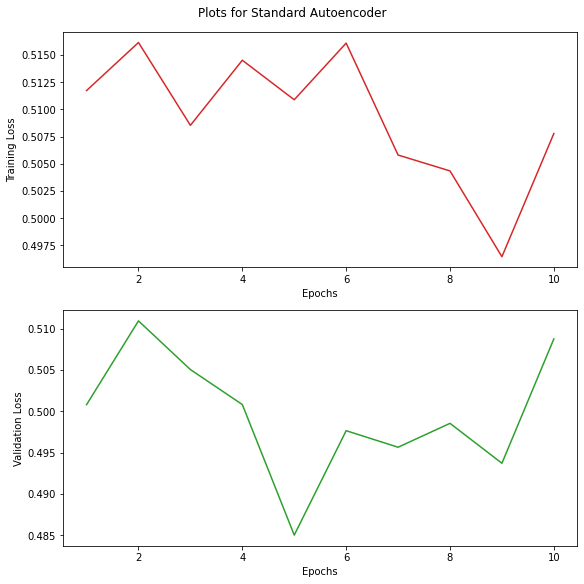

Training done for denoising AE with noise value 0.8 !
-----------------------------------------------------------


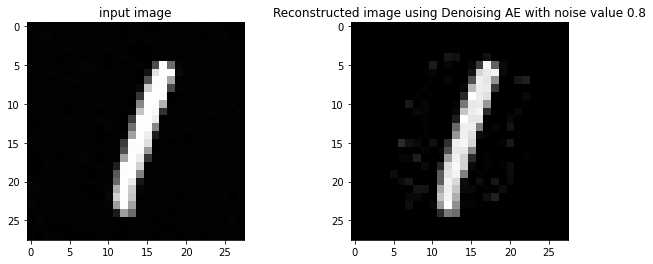

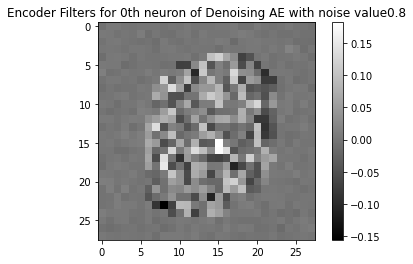

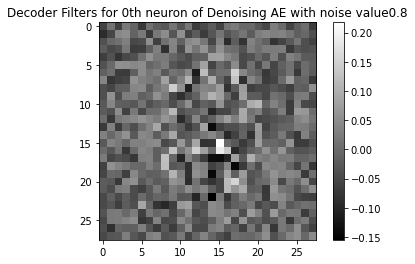

-----------------------------------------------------------
-----------------------------------------------------------
Training begins for noise value  0.9 !
-----------------------------------------------------------
Epoch Number:  1
Training loss:  0.6532461047172546
Validation loss:  0.6429724097251892
-----------------------------------------
Epoch Number:  2
Training loss:  0.6543552279472351
Validation loss:  0.6423315405845642
-----------------------------------------
Epoch Number:  3
Training loss:  0.6487111449241638
Validation loss:  0.6369641423225403
-----------------------------------------
Epoch Number:  4
Training loss:  0.657607913017273
Validation loss:  0.6441336274147034
-----------------------------------------
Epoch Number:  5
Training loss:  0.6530838012695312
Validation loss:  0.625943124294281
-----------------------------------------
Epoch Number:  6
Training loss:  0.6320071816444397
Validation loss:  0.6512637138366699
---------------------------------------

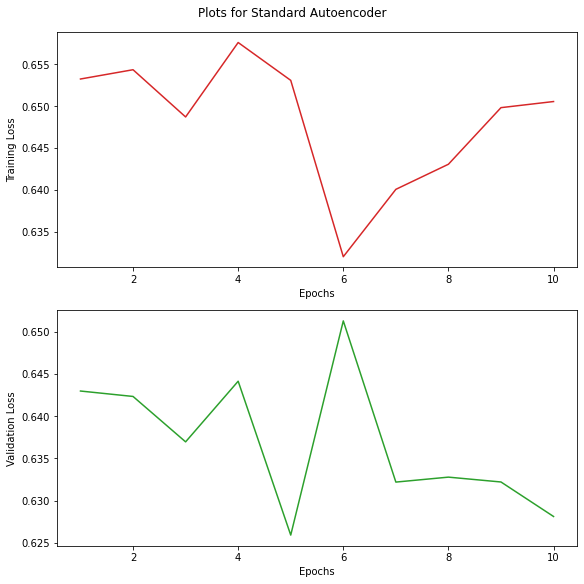

Training done for denoising AE with noise value 0.9 !
-----------------------------------------------------------


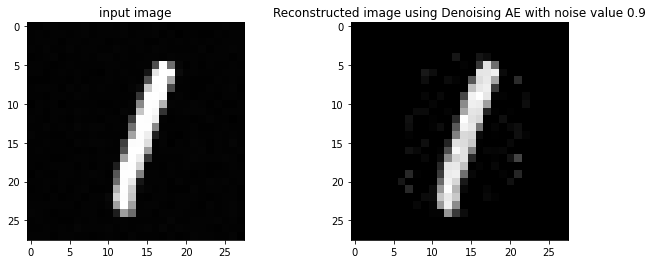

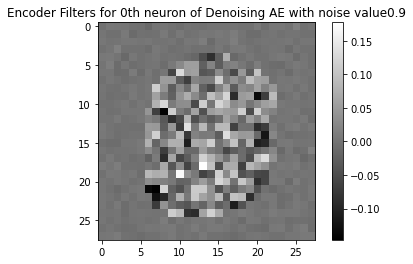

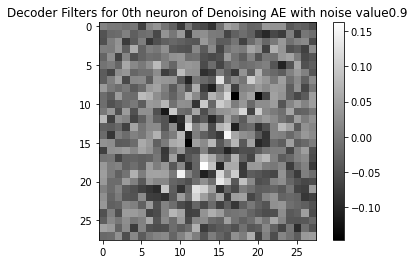

-----------------------------------------------------------
-----------------------------------------------------------


In [21]:
noise_values = [0.3, 0.5, 0.8, 0.9]

for noise_val in noise_values:
  model_denoiseAE = standard_AE(256).to(device)
  optimizer = torch.optim.Adam(model_denoiseAE.parameters(), learning_rate)

  train_batch_loss = []
  train_epoch_loss = []
  val_loss = []
  print('Training begins for noise value ', noise_val, '!')
  print('-----------------------------------------------------------') 
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):

      noise = torch.randn(data.size())*noise_val
      data = data + noise
      data = data.to(device=device)
      target = target.to(device=device)

      model_denoiseAE.train()
      decoded, encoded = model_denoiseAE(data)
      loss = criterion(decoded, torch.flatten(data,1))
      train_batch_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_epoch_loss.append(train_batch_loss[-1])
  
    model_denoiseAE.eval()
    with torch.no_grad():
      for (data, target) in test_loader:
        noise = torch.randn(data.size())*noise_val
        data = data + noise
        data = data.to(device=device)
        target = target.to(device)
        decoded, encoded = model_denoiseAE(data)
        val_iter_loss = criterion(decoded, torch.flatten(data,1))

    val_loss.append(val_iter_loss.item())
    print('Epoch Number: ',epoch+1)
    print('Training loss: ', train_epoch_loss[-1])
    print('Validation loss: ', val_loss[-1])
    print('-----------------------------------------')

  
  fig, axs = plt.subplots(2, constrained_layout= True, figsize=(8,8))
  fig.suptitle('Plots for Standard Autoencoder')
  axs[0].set(ylabel='Training Loss', xlabel='Epochs')
  axs[0].plot(range(1,epochs+1),train_epoch_loss, 'tab:red')
  axs[1].set(ylabel='Validation Loss', xlabel='Epochs')
  axs[1].plot(range(1,epochs+1),val_loss, 'tab:green')
  plt.show()
  print('Training done for denoising AE with noise value',noise_val,'!')
  print('-----------------------------------------------------------')
  test_image = test_loader.dataset.data[5, :, :].clone() #RANDOM TEST IMAGE
  noise = torch.randn(test_image.size())*noise_val
  image = test_image + noise
  with torch.no_grad():
    image = image.view(-1,28,28).to(device=device).float()
    decoded, encoded = model_denoiseAE.forward(image)
    decoded = decoded.detach().cpu().numpy()
    image = image.reshape(28,28).detach().cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(image , cmap='gray')
    plt.title('input image')
    plt.subplots_adjust(right=1.5)
    plt.subplot(1,2,2)
    plt.imshow(decoded.reshape(28,28),cmap ='gray')
    plt.title("Reconstructed image using Denoising AE with noise value "+str(noise_val))
    plt.show()
  encoder_decoder_filters_plots( model_denoiseAE,"Denoising AE with noise value"+str(noise_val),device)
  print('-----------------------------------------------------------')
  print('-----------------------------------------------------------')


**Observations**

- As the noise value is increased, the reconstruction becomes worse but the shape of the digits are still recognizable. 

- The learned filters are more focused and have higher variation in pixel values as the noise value increases. 